<a href="https://colab.research.google.com/github/Manonlks5/PROJET_DDEFI_2025/blob/main/Code_projet_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy yfinance statsmodels openpyxl fredapi

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from fredapi import Fred

# Replace this with your actual FRED API key
FRED_API_KEY = 'your_fred_api_key_here'

# Step 1: Generate a list of dates (daily from January 2019 to January 2024)
def generate_dates():
    start_date = datetime(2018, 1, 1)
    end_date = datetime(2024, 1, 1)
    dates = []

    while start_date <= end_date:
        dates.append(start_date.strftime('%Y-%m-%d'))
        start_date += timedelta(days=1)  # Increment by 1 day

    return dates

# Step 2: Get historical data for S&P 500, VIX, and Treasury yields
def get_sp500_data_with_exogenous(dates):
    try:
        # S&P 500 and VIX historical data
        sp500 = yf.Ticker("^GSPC")
        vix = yf.Ticker("^VIX")
        sp500_hist = sp500.history(start="2018-01-01", end="2024-01-01")
        vix_hist = vix.history(start="2018-01-01", end="2024-01-01")

        # Identifier for Treasury yield (3-month Treasury yield)
        tickers = {
            "3mo": "^IRX",  # 3-month Treasury yield
        }

        data_FED = []
        # Download Treasury yield data
        for label, ticker in tickers.items():
            print(f"T√©l√©chargement des donn√©es pour {label} ({ticker})...")
            df = yf.download(ticker, start="2018-01-01", end="2024-01-01")
            df["Yield"] = df["Close"]  # Use the 'Close' column for the yields
            df = df[["Yield"]]  # Keep only the yield data
            df.rename(columns={"Yield": label}, inplace=True)
            data_FED.append(df)

        # Combine the Treasury yield data
        yield_curve = pd.concat(data_FED, axis=1, join="inner")
        yield_curve.reset_index(inplace=True)
        yield_curve.rename(columns={"Date": "Date"}, inplace=True)

        # Create the data list with merged information
        data = []
        start_date = pd.to_datetime('2018-01-01')  # D√©finir la date de d√©but
        for date in dates:
            try:
              if pd.to_datetime(date) >= start_date:
                # Retrieve S&P 500 data for the current date
                price = sp500_hist.loc[date, 'Close']
                volume = sp500_hist.loc[date, 'Volume']
                vix_value = vix_hist.loc[date, 'Close']

                # Get the Treasury yield for the current date
                treasury_rate = yield_curve.loc[yield_curve['Date'] == date, '3mo'].values[0]

                # Append all data as a row
                data.append((date, price, volume, vix_value, treasury_rate))
            except KeyError:
                pass  # Skip dates where data is missing

        # Create the final DataFrame
        final_df = pd.DataFrame(data, columns=["Date", "Close", "Volume", "VIX", "3mo_Treasury_Rate"])

        # Save the DataFrame to an Excel file
        output_file = "sp500_with_treasury_yield_data.xlsx"
        final_df.to_excel(output_file, index=False)
        print(f"Data saved to {output_file}")
        return final_df

    except Exception as e:
        print(f"Error retrieving data: {e}")
        return pd.DataFrame()



# Main logic
if __name__ == "__main__":
    # Generate daily dates
    dates = generate_dates()

    # Fetch all data
    full_data = get_sp500_data_with_exogenous(dates)

    # Save to Excel
    if not full_data.empty:
        output_file = "sp500_full_data.xlsx"
        full_data.to_excel(output_file, index=False)
        print(f"Data successfully saved to {output_file}")
    else:
        print("No data to save.")


#La valeur 3223050000 pour le volume signifie qu'environ 3,223,050,000 actions (soit environ 3,2 milliards d'actions)
# ont √©t√© √©chang√©es sur l'ensemble des composantes du S&P 500 au cours de cette journ√©e sp√©cifique.

T√©l√©chargement des donn√©es pour 3mo (^IRX)...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data saved to sp500_with_treasury_yield_data.xlsx
Data successfully saved to sp500_full_data.xlsx


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Step 1: Load and clean data
def load_and_clean_data():
    # Charger les donn√©es g√©n√©r√©es par le code pr√©c√©dent
    input_file = "sp500_full_data.xlsx"
    data = pd.read_excel(input_file)

    # Supprimer les doublons
    data = data.drop_duplicates()

    # G√©rer les valeurs manquantes
    data = data.dropna()  # Supprimer les lignes avec des valeurs manquantes
    return data

# Step 2: Transform prices into log-returns
def compute_log_returns(data):
    # Ajouter une colonne des rendements log
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    return data.dropna()  # Supprimer les lignes NaN cr√©√©es par le d√©calage

# Step 3: Perform stationarity analysis (ADF Test)
def test_stationarity(data, column):
    result = adfuller(data[column], autolag='AIC')
    print(f"ADF Test for {column}:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
    return result

# Main logic
if __name__ == "__main__":
    # Charger et nettoyer les donn√©es
    data = load_and_clean_data()

    # Calculer les rendements log
    data = compute_log_returns(data)

    # Effectuer le test ADF sur les rendements log
    test_stationarity(data, 'Log_Returns')

    # Enregistrer le dataset nettoy√© et enrichi avec les d√©calages
    output_file = "sp500_cleaned.xlsx"
    data.to_excel(output_file, index=False)
    print(f"Cleaned data with log-returns saved to {output_file}")

ADF Test for Log_Returns:
Test Statistic: -11.853423740881892
P-Value: 7.119616583190098e-22
Critical Values: {'1%': -3.4347199356122493, '5%': -2.86347004827819, '10%': -2.567797534300163}
The series is stationary.
Cleaned data with log-returns saved to sp500_cleaned.xlsx


In [ ]:
pip install pandas openpyxl ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ac955720d8a7350d7d25b515d1ad972992ee44723e583ae5064decfde324d031
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import pandas as pd
import ta

# Charger le fichier Excel
fichier_excel = "sp500_cleaned.xlsx"
df = pd.read_excel(fichier_excel)

# V√©rifier les premi√®res lignes pour confirmer la structure
print(df.head())

# Nettoyer et v√©rifier les colonnes
if "Close" not in df.columns:
    raise ValueError("Le fichier doit contenir une colonne nomm√©e 'Close' pour les prix de cl√¥ture.")

# V√©rifier et convertir la colonne "Date" en datetime
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by="Date")  # Trier par date
else:
    raise ValueError("Le fichier doit contenir une colonne nomm√©e 'Date'.")

# Ajouter des indicateurs techniques en utilisant toutes les donn√©es
df["SMA_50"] = df["Close"].rolling(window=50).mean()
df["SMA_200"] = df["Close"].rolling(window=200).mean()

# RSI (Relative Strength Index) sur 14 jours
df["RSI_14"] = ta.momentum.RSIIndicator(close=df["Close"], window=14).rsi()

# MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df["Close"])
df["MACD"] = macd.macd()            # Ligne MACD
df["MACD_Signal"] = macd.macd_signal()  # Ligne Signal
df["MACD_Hist"] = macd.macd_diff()  # Histogramme MACD

# Filtrer les donn√©es pour inclure uniquement celles √† partir du 1er janvier 2019
start_date = pd.to_datetime("2019-01-01")
df_filtered = df[df["Date"] >= start_date]

# V√©rifier les donn√©es apr√®s filtrage
print(df_filtered.head())

# Sauvegarder les donn√©es enrichies dans un nouveau fichier Excel
fichier_sortie = "s&p500_with_indicators_2019.xlsx"
df_filtered.to_excel(fichier_sortie, index=False)

print(f"Fichier enrichi avec indicateurs sauvegard√© sous : {fichier_sortie}")


         Date        Close      Volume    VIX  3mo_Treasury_Rate  Log_Returns
0  2018-01-03  2713.060059  3544030000   9.15              1.370     0.006378
1  2018-01-04  2723.989990  3697340000   9.22              1.370     0.004021
2  2018-01-05  2743.149902  3239280000   9.22              1.370     0.007009
3  2018-01-08  2747.709961  3246160000   9.52              1.380     0.001661
4  2018-01-09  2751.290039  3467460000  10.08              1.415     0.001302
          Date        Close      Volume        VIX  3mo_Treasury_Rate  \
250 2019-01-02  2510.030029  3733160000  23.219999              2.365   
251 2019-01-03  2447.889893  3858830000  25.450001              2.355   
252 2019-01-04  2531.939941  4234140000  21.379999              2.358   
253 2019-01-07  2549.689941  4133120000  21.400000              2.353   
254 2019-01-08  2574.409912  4120060000  20.469999              2.400   

     Log_Returns       SMA_50     SMA_200     RSI_14       MACD  MACD_Signal  \
250     0.001

        Date        Close      Volume        VIX  3mo_Treasury_Rate  \
0 2019-01-02  2510.030029  3733160000  23.219999              2.365   
1 2019-01-03  2447.889893  3858830000  25.450001              2.355   
2 2019-01-04  2531.939941  4234140000  21.379999              2.358   
3 2019-01-07  2549.689941  4133120000  21.400000              2.353   
4 2019-01-08  2574.409912  4120060000  20.469999              2.400   

   Log_Returns       SMA_50     SMA_200     RSI_14       MACD  MACD_Signal  \
0     0.001268  2655.941201  2744.79245  42.127431 -60.803987   -61.695988   
1    -0.025068  2649.543398  2743.46730  36.601730 -61.283265   -61.613443   
2     0.033759  2645.064600  2742.54230  46.771618 -54.255535   -60.141861   
3     0.006986  2641.244600  2741.73110  48.645167 -46.715228   -57.456535   
4     0.009649  2639.610796  2741.38470  51.220276 -38.303249   -53.625878   

   MACD_Hist  
0   0.892000  
1   0.330178  
2   5.886327  
3  10.741307  
4  15.322629  


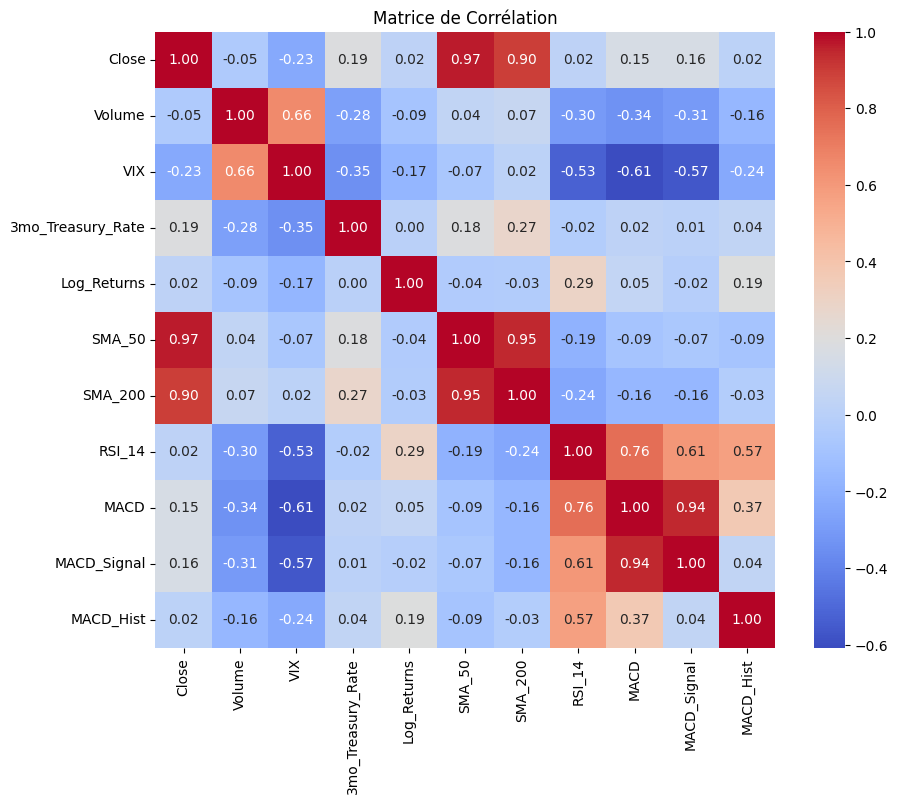

Corr√©lation avec 'Close':
Close                1.000000
SMA_50               0.967979
SMA_200              0.897138
3mo_Treasury_Rate    0.189502
MACD_Signal          0.157276
MACD                 0.152541
RSI_14               0.022767
Log_Returns          0.021035
MACD_Hist            0.018486
Volume              -0.047497
VIX                 -0.230662
Name: Close, dtype: float64

Variables s√©lectionn√©es avec SelectKBest :
Index(['VIX', '3mo_Treasury_Rate', 'SMA_50', 'SMA_200', 'MACD_Signal'], dtype='object')

Fichier avec features s√©lectionn√©es sauvegard√© sous : s&p500_selected_features_2019.xlsx


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression

# Charger le fichier enrichi
fichier_enrichi = "s&p500_with_indicators_2019.xlsx"
df = pd.read_excel(fichier_enrichi)

# V√©rifier les premi√®res lignes pour confirmer la structure
print(df.head())

# Supprimer les colonnes non pertinentes (par exemple, Date si elle n'est pas une variable num√©rique)
df_numeric = df.drop(columns=["Date"])

# Calculer la matrice de corr√©lation
correlation_matrix = df_numeric.corr()

# Visualiser la matrice de corr√©lation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de Corr√©lation")
plt.show()

# Identifier les variables ayant une forte corr√©lation avec la variable cible 'Close'
correlation_with_close = correlation_matrix["Close"].sort_values(ascending=False)
print("Corr√©lation avec 'Close':")
print(correlation_with_close)

# S√©lectionner les 5 meilleures features en utilisant SelectKBest
X = df_numeric.drop(columns=["Close"])  # Variables ind√©pendantes
y = df_numeric["Close"]  # Variable cible

# Appliquer SelectKBest avec la m√©thode de r√©gression F
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)

# Obtenir les noms des variables s√©lectionn√©es
selected_features = X.columns[selector.get_support()]
print("\nVariables s√©lectionn√©es avec SelectKBest :")
print(selected_features)

# Cr√©er un nouveau dataframe avec les features s√©lectionn√©es
df_selected = df[["Date", "Close"] + list(selected_features)]

# Sauvegarder les donn√©es dans un fichier Excel
fichier_sortie = "s&p500_selected_features_2019.xlsx"
df_selected.to_excel(fichier_sortie, index=False)

print(f"\nFichier avec features s√©lectionn√©es sauvegard√© sous : {fichier_sortie}")


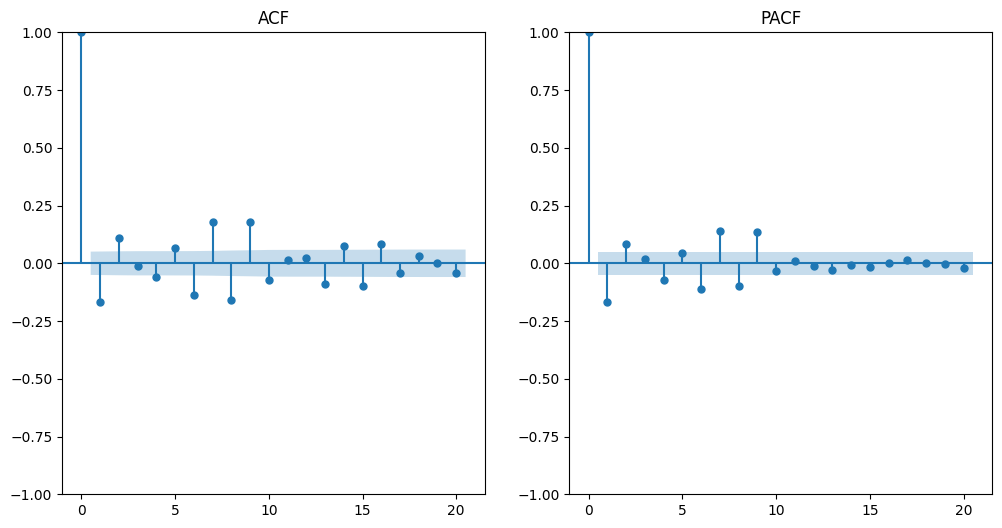

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Meilleur ordre ARIMA: (0, 0, 2) avec AIC: -8848.169579904614
Validation crois√©e temporelle (rolling window)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Mean Absolute Error (MAE): 0.0076
Root Mean Squared Error (RMSE): 0.0099
Accuracy (Pr√©cision directionnelle): 0.4636


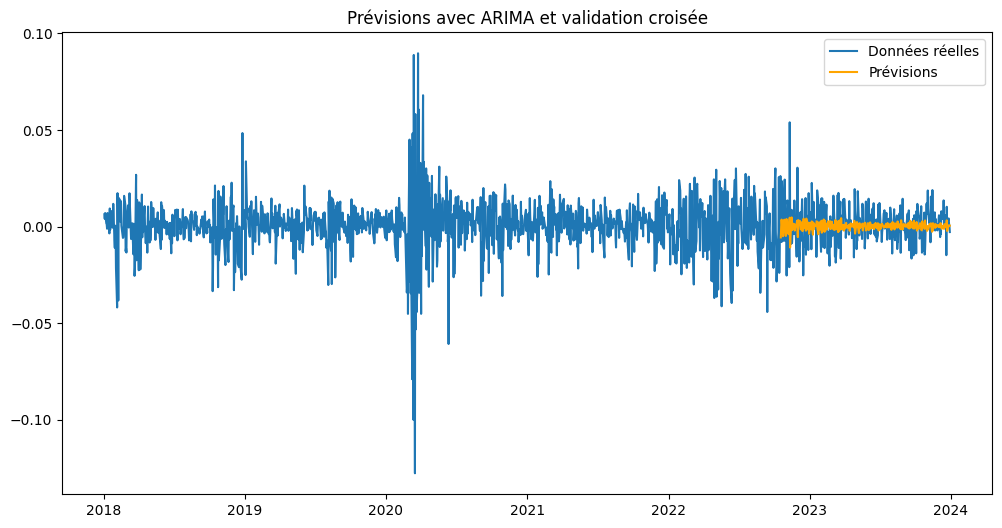

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

# Charger la s√©rie stationnaire
def load_stationary_series():
    input_file = "sp500_cleaned.xlsx"
    series = pd.read_excel(input_file, index_col="Date", parse_dates=True)
    return series

# Tracer ACF et PACF
def plot_acf_pacf(series):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=20)
    plt.title("ACF")

    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=20)
    plt.title("PACF")
    plt.show()

# Recherche de l'ordre optimal pour ARIMA avec AIC/BIC
def find_best_arima(series, p_range, q_range, d=0):
    best_aic = float("inf")
    best_order = None
    for p, q in itertools.product(p_range, q_range):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
        except:
            continue
    print(f"Meilleur ordre ARIMA: {best_order} avec AIC: {best_aic}")
    return best_order

# Fonction de validation crois√©e temporelle
def rolling_window_cv(series, order, train_ratio=0.8, forecast_steps=1):
    n = len(series)
    train_size = int(n * train_ratio)
    test_size = n - train_size

    train = series[:train_size]
    test = series[train_size:]

    predictions = []
    actuals = []

    print("Validation crois√©e temporelle (rolling window)...")
    for i in range(len(test) - forecast_steps + 1):
        train_window = series[:train_size + i]
        test_point = series[train_size + i:train_size + i + forecast_steps]

        model = ARIMA(train_window, order=order)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=forecast_steps)
        predictions.extend(forecast)
        actuals.extend(test_point.values)

    return actuals, predictions

# Calculer les m√©triques d'√©valuation
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Correction : Comparer les directions (hausse/baisse)
    accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))  # Pr√©cision directionnelle
    return mae, rmse, accuracy

# Tracer les r√©sultats
def plot_results(series, actuals, predictions, train_ratio):
    train_size = int(len(series) * train_ratio)

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label="Donn√©es r√©elles")
    plt.plot(series.index[train_size:], predictions, label="Pr√©visions", color="orange")
    plt.legend()
    plt.title("Pr√©visions avec ARIMA et validation crois√©e")
    plt.show()

# Main logic
if __name__ == "__main__":
    # Charger la s√©rie stationnaire
    series = load_stationary_series()["Log_Returns"]

    # Tracer ACF et PACF pour d√©terminer p et q
    plot_acf_pacf(series)

    # D√©terminer l'ordre optimal de ARIMA avec une recherche exhaustive
    p_range = range(0, 4)  # Test pour p = 0, 1, 2, 3
    q_range = range(0, 4)  # Test pour q = 0, 1, 2, 3
    best_order = find_best_arima(series, p_range, q_range, d=0)  # d = 0 car la s√©rie est stationnaire

    # Validation crois√©e temporelle avec le meilleur ordre ARIMA
    actuals, predictions = rolling_window_cv(series, best_order)

    # Calculer les m√©triques
    mae, rmse, accuracy = evaluate_model(actuals, predictions)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Accuracy (Pr√©cision directionnelle): {accuracy:.4f}")

    # Tracer les r√©sultats
    plot_results(series, actuals, predictions, train_ratio=0.8)


<ipython-input-9-90efb1f058c3>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i])  # Le rendement du jour √† pr√©dire


Mean Absolute Error (MAE): 0.0076
Root Mean Squared Error (RMSE): 0.0099


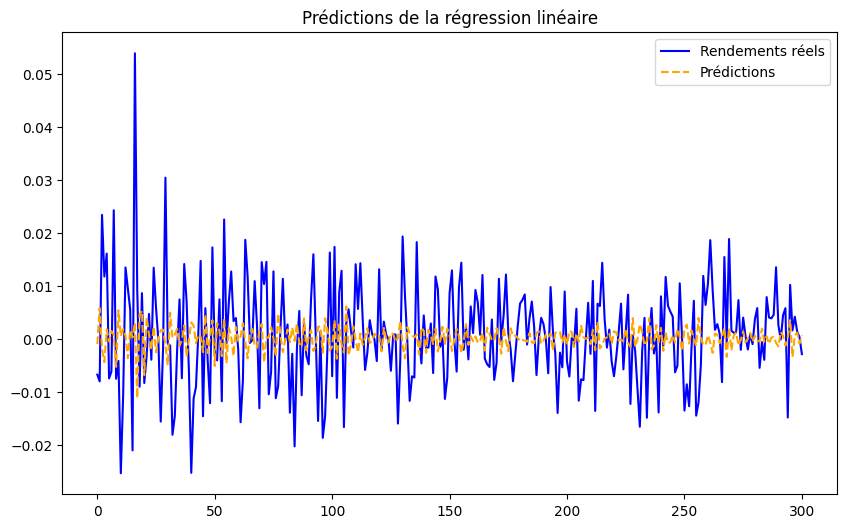

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Charger la s√©rie temporelle
def load_stationary_series():
    input_file = "sp500_cleaned.xlsx"
    series = pd.read_excel(input_file, index_col="Date", parse_dates=True)
    return series

# Fonction pour pr√©parer les caract√©ristiques (features) et les cibles (targets)
def prepare_data(series, lag=1):
    X = []
    y = []

    # Utilisation des rendements pass√©s pour pr√©dire les rendements futurs
    for i in range(lag, len(series)):
        X.append(series[i-lag:i].values)  # Les rendements des jours pr√©c√©dents comme caract√©ristiques
        y.append(series[i])  # Le rendement du jour √† pr√©dire

    return np.array(X), np.array(y)

# Fonction pour entra√Æner et √©valuer le mod√®le de r√©gression lin√©aire
def train_and_evaluate_linear_regression(X_train, y_train, X_test, y_test):
    # Initialisation du mod√®le de r√©gression lin√©aire
    model = LinearRegression()

    # Entra√Ænement du mod√®le
    model.fit(X_train, y_train)

    # Pr√©diction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des m√©triques d'√©valuation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Retourner les m√©triques
    return mae, rmse, y_pred

# Fonction pour tracer les r√©sultats
def plot_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Rendements r√©els", color="blue")
    plt.plot(y_pred, label="Pr√©dictions", color="orange", linestyle='--')
    plt.legend()
    plt.title("Pr√©dictions de la r√©gression lin√©aire")
    plt.show()

# Main logic
if __name__ == "__main__":
    # Charger la s√©rie temporelle
    series = load_stationary_series()["Log_Returns"]

    # Pr√©parer les donn√©es avec des d√©calages (lags)
    lag = 5  # Utiliser les 5 derniers rendements pour pr√©dire le rendement suivant
    X, y = prepare_data(series, lag=lag)

    # Diviser les donn√©es en ensembles d'entra√Ænement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Entra√Æner et √©valuer le mod√®le de r√©gression lin√©aire
    mae, rmse, y_pred = train_and_evaluate_linear_regression(X_train, y_train, X_test, y_test)

    # Afficher les m√©triques
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Tracer les r√©sultats
    plot_results(y_test, y_pred)


In [ ]:
pip install pytrends

In [ ]:
#Renvoie un score relatif par semaine de recherche sp500 sur google (100 = jour avec le plus de recherche)

import pandas as pd
from pytrends.request import TrendReq
import time

# Initialiser pytrends
pytrends = TrendReq(hl='en-US', tz=0)

# D√©finir les param√®tres
keyword = "S&P 500"  # Mot-cl√© √† analyser
start_date = "2019-01-01"
end_date = "2023-12-31"

# R√©cup√©rer les donn√©es de tendance journali√®res
pytrends.build_payload([keyword], timeframe=f"{start_date} {end_date}", geo="", gprop="")

# T√©l√©charger les tendances journali√®res
data = pytrends.interest_over_time()

# Nettoyage du DataFrame
if "isPartial" in data.columns:
    data = data.drop(columns=["isPartial"])  # Supprime la colonne indiquant les donn√©es incompl√®tes

# Sauvegarder en Excel
data.to_excel("google_trends_sp500.xlsx")

print("Donn√©es Google Trends enregistr√©es dans google_trends_sp500.xlsx")


Donn√©es Google Trends enregistr√©es dans google_trends_sp500.xlsx


In [ ]:
pip install requests beautifulsoup4

In [ ]:
!pip install gdeltdoc




In [ ]:
!pip show gdeltdoc


Name: gdeltdoc
Version: 1.5.0
Summary: A client for the GDELT 2.0 Doc API
Home-page: https://github.com/alex9smith/gdelt-doc-api
Author: Alex Smith
Author-email: alex@alexsmith.dev
License: UNKNOWN
Location: /usr/local/lib/python3.11/dist-packages
Requires: pandas, requests
Required-by: 


In [ ]:
# Collecte des articles gr√¢ce √† GDELT

from gdeltdoc import GdeltDoc, Filters
import pandas as pd

# Initialiser le client GDELT
gd = GdeltDoc()

# D√©finir la p√©riode par mois
date_ranges = pd.date_range(start='2020-01-01', end='2025-03-01', freq='MS')  # MS = Month Start

# Liste pour stocker tous les articles
all_articles = []

# Boucle sur chaque mois pour r√©cup√©rer les articles
for date in date_ranges:
    start_date = date.strftime('%Y-%m-%d')
    end_date = (date + pd.DateOffset(months=1) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    print(f"üîç Recherche d'articles de {start_date} √† {end_date}...")

    # D√©finir les filtres pour ce mois
    f = Filters(
        keyword='SP500',
        start_date=start_date,
        end_date=end_date
    )

    # Effectuer la requ√™te
    articles = gd.article_search(f)

    # V√©rifier si c'est un DataFrame
    if isinstance(articles, pd.DataFrame) and not articles.empty:
        # Supprimer les doublons
        articles = articles.drop_duplicates(subset=['title'])

        # Ajouter les articles √† la liste principale
        all_articles.append(articles)

# Fusionner tous les articles en un seul DataFrame
if all_articles:
    final_articles = pd.concat(all_articles).drop_duplicates(subset=['title'])

    # Sauvegarde des articles dans un fichier Excel
    final_articles.to_excel('SP500_Articles_2023_2024.xlsx', index=False)
    print("\n‚úÖ Tous les articles ont √©t√© enregistr√©s dans 'SP500_Articles_2023_2024.xlsx'.")
else:
    print("\n‚ö†Ô∏è Aucun article trouv√© pour la p√©riode demand√©e.")


üîç Recherche d'articles de 2020-01-01 √† 2020-01-31...
üîç Recherche d'articles de 2020-02-01 √† 2020-02-29...
üîç Recherche d'articles de 2020-03-01 √† 2020-03-31...
üîç Recherche d'articles de 2020-04-01 √† 2020-04-30...
üîç Recherche d'articles de 2020-05-01 √† 2020-05-31...
üîç Recherche d'articles de 2020-06-01 √† 2020-06-30...
üîç Recherche d'articles de 2020-07-01 √† 2020-07-31...
üîç Recherche d'articles de 2020-08-01 √† 2020-08-31...
üîç Recherche d'articles de 2020-09-01 √† 2020-09-30...
üîç Recherche d'articles de 2020-10-01 √† 2020-10-31...
üîç Recherche d'articles de 2020-11-01 √† 2020-11-30...
üîç Recherche d'articles de 2020-12-01 √† 2020-12-31...
üîç Recherche d'articles de 2021-01-01 √† 2021-01-31...
üîç Recherche d'articles de 2021-02-01 √† 2021-02-28...
üîç Recherche d'articles de 2021-03-01 √† 2021-03-31...
üîç Recherche d'articles de 2021-04-01 √† 2021-04-30...
üîç Recherche d'articles de 2021-05-01 √† 2021-05-31...
üîç Recherche d'articles de 20

In [ ]:
#Tri des articles selon 3 cat√©gories diff√©rentes : "Neutral" , "Greed", "Fear"

from gdeltdoc import GdeltDoc, Filters
import pandas as pd

# Charger le fichier Excel fourni
file_path = "/content/SP500_Articles_2023_2024.xlsx"
df = pd.read_excel(file_path)

# D√©finition des mots-cl√©s pour Fear et Greed
fear_keywords = [
    #  Sentiment N√©gatif G√©n√©ral
    "bear market", "market crash", "sell-off", "recession", "fear", "panic", "turmoil",
    "uncertainty", "volatility", "instability", "plunge", "drop", "decline", "sell pressure",

    #  Catastrophe Financi√®re
    "collapse", "bubble burst", "depression", "slowdown", "economic downturn", "financial crisis",
    "bank run", "credit crunch", "sovereign debt crisis", "contagion", "default", "bankruptcy",
    "mass liquidation", "market turmoil", "high yield spreads widening",

    #  Indicateurs de Stress √âconomique
    "yield curve inversion", "interest rate hike", "inflation", "hyperinflation", "stagflation",
    "debt ceiling crisis", "currency devaluation", "soaring bond yields", "credit crisis",

    #  Actions de la Fed & Politiques Restrictives
    "federal reserve tightening", "hawkish fed", "quantitative tightening", "rate hike fears",
    "tightening cycle", "liquidity squeeze", "monetary contraction",

    #  Indicateurs d'Extr√™me Panique
    "fear index", "high volatility", "risk-off", "mass layoffs", "financial distress",
    "negative earnings growth", "downgrade risk", "systemic risk", "fund outflows"
]


greed_keywords = [
    #  Sentiment Positif G√©n√©ral
    "bull market", "rally", "buying frenzy", "greed", "all-time high", "record close", "ATH",
    "breakout", "run-up", "momentum buying", "euphoria", "market frenzy",

    #  Boom du March√© & Sp√©culation
    "parabolic move", "speculation", "optimism", "boom", "exuberance", "risk-on", "FOMO",
    "buy the dip", "market mania", "overbought", "overvalued", "margin expansion",

    #  Performances Exceptionnelles
    "record high", "historic gains", "new peak", "unstoppable rally", "multi-year high",
    "biggest daily gain", "best quarter in history", "blue sky breakout",

    #  Indicateurs de Liquidit√© & Monnaie Facile
    "low volatility", "easy money", "liquidity injection", "quantitative easing",
    "stimulus-driven", "asset bubble", "wealth effect", "leveraged buying",

    #  Actions de la Fed & Politiques Accommodantes
    "federal reserve dovish", "interest rate cut", "accommodative policy", "QE program",
    "low interest rates", "monetary easing", "stimulus checks", "economic expansion",

    #  Secteurs en Pleine Croissance
    "growth stocks surging", "IPO boom", "crypto boom", "NFT frenzy", "SPAC mania",
    "tech stocks soaring", "AI stocks rally", "clean energy boom", "EV stocks breakout"
]

neutral_keywords = [
    #  Analyses et √âtudes Macro√©conomiques
    "economic outlook", "market overview", "GDP growth", "labor market", "CPI report",
    "interest rate decision", "earnings report", "macroeconomic trends", "central bank update",

    #  Politique Mon√©taire et √âv√©nements √âconomiques
    "Fed meeting", "policy update", "inflation data", "consumer confidence", "unemployment rate",
    "market reaction", "financial stability report", "economic indicators",

    #  √âv√©nements Neutres sur les March√©s
    "quarterly results", "market digest", "stock valuation", "company earnings",
    "market forecast", "fiscal policy", "trade balance", "bond yields movement",

    #  Banques, Institutions et Politiques Financi√®res
    "ECB policy", "global markets", "corporate earnings", "stock buybacks", "dividends",
    "regulatory update", "institutional investors"
]


# Filtrer les articles en fonction des mots-cl√©s

# Assigner "Fear" si le titre contient un mot-cl√© de Fear
df.loc[df['title'].str.contains('|'.join(fear_keywords), case=False, na=False), "Category"] = "Fear"

# Assigner "Greed" si le titre contient un mot-cl√© de Greed
df.loc[df['title'].str.contains('|'.join(greed_keywords), case=False, na=False), "Category"] = "Greed"

df.loc[df['title'].str.contains('|'.join(neutral_keywords), case=False, na=False), "Category"] = "Neutral"

# Garder uniquement les articles class√©s en Fear ou Greed
filtered_df = df[df["Category"].isin(["Fear", "Greed","Neutral"])]

# Reformater la date (Ann√©e/Mois/Jour)
filtered_df["Formatted Date"] = filtered_df["seendate"].str[:8]  # Garder YYYYMMDD
filtered_df["Formatted Date"] = pd.to_datetime(filtered_df["Formatted Date"], format="%Y%m%d").dt.strftime("%Y/%m/%d")

# Trier les articles par date (du plus r√©cent au plus ancien)
filtered_df = filtered_df.sort_values(by="Formatted Date", ascending=False)

# S√©lectionner les colonnes utiles
filtered_df = filtered_df[["Formatted Date", "title", "Category", "url"]]

# Sauvegarder le fichier filtr√© **dans le bon chemin**
filtered_file_path = "/content/SP500_Fear_Greed_Articles.xlsx"
filtered_df.to_excel(filtered_file_path, index=False)

# Message de confirmation
print(f"\n‚úÖ Fichier enregistr√© : {filtered_file_path}")

# T√©l√©charger le fichier filtr√©
from google.colab import files
files.download(filtered_file_path)




‚úÖ Fichier enregistr√© : /content/SP500_Fear_Greed_Articles.xlsx


<ipython-input-16-86954b91bc75>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Formatted Date"] = filtered_df["seendate"].str[:8]  # Garder YYYYMMDD
<ipython-input-16-86954b91bc75>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Formatted Date"] = pd.to_datetime(filtered_df["Formatted Date"], format="%Y%m%d").dt.strftime("%Y/%m/%d")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install pytrends
!pip install praw
!pip install fredapi


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 189.3/189.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Test pour r√©cup√©rer les tweets sur Reddit mais cela n'a pas fonctionn√© comme nous avons √©nonc√© dans le GITHUB.
# On vous laisse le code si vous pouvez peut-√™tre voir pourquoi on n'a pas r√©ussi.
# J'ai essay√© de cr√©er des fichiers √† chaque fois pour r√©cup√©rer les donn√©es puis tout concat√©ner mais sans r√©sultats


import praw
import pandas as pd
import datetime
import time
import os

# Connexion √† l'API Reddit avec un User-Agent personnalis√©
reddit = praw.Reddit(client_id='451681wPbHGeaAs7j_leWA',
                     client_secret='V5z91Re9lbNChC36OjdNSKVOL3gCQw',
                     user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                     check_for_async=False)

# üìå Mots-cl√©s pour filtrer les posts li√©s au S&P 500
keywords = ["S&P 500", "SP500", "stock market", "bull market", "bear market", "crash", "inflation", "interest rates"]

# üìÅ Dossier temporaire pour stocker les fichiers quotidiens
temp_folder = "/mnt/data/reddit_temp"
os.makedirs(temp_folder, exist_ok=True)

def get_reddit_data_day(subreddit_name, date, posts_per_day=10):
    """R√©cup√®re les posts Reddit pour un jour donn√©"""
    subreddit = reddit.subreddit(subreddit_name)

    print(f"üìÖ R√©cup√©ration des posts pour {date.strftime('%Y-%m-%d')}...")

    # Convertir la date en timestamp UNIX
    start_timestamp = int(date.timestamp())
    end_timestamp = int((date + datetime.timedelta(days=1)).timestamp())

    # Liste des posts du jour
    daily_posts = []

    for keyword in keywords:
        for post in subreddit.search(f"{keyword} timestamp:{start_timestamp}..{end_timestamp}",
                                     syntax='cloudsearch', sort='desc', limit=posts_per_day // len(keywords)):
            daily_posts.append({
                'date': date.strftime('%Y-%m-%d'),
                'title': post.title,
                'score': post.score,
                'num_comments': post.num_comments,
                'created_utc': datetime.datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                'url': post.url
            })

    print(f"‚úÖ {len(daily_posts)} posts r√©cup√©r√©s pour {date.strftime('%Y-%m-%d')}")

    return pd.DataFrame(daily_posts)

def save_day_data(date, df):
    """Sauvegarde les donn√©es d'une journ√©e dans un fichier temporaire"""
    file_path = os.path.join(temp_folder, f"reddit_{date.strftime('%Y-%m-%d')}.xlsx")
    df.to_excel(file_path, index=False)
    print(f"üìÇ Donn√©es de {date.strftime('%Y-%m-%d')} enregistr√©es dans {file_path}")

def merge_all_data():
    """Fusionne tous les fichiers journaliers en un seul fichier Excel"""
    all_files = [os.path.join(temp_folder, f) for f in os.listdir(temp_folder) if f.endswith(".xlsx")]

    if not all_files:
        print("‚ùå Aucun fichier trouv√© pour fusion.")
        return None

    # Charger et fusionner tous les fichiers Excel
    df_list = [pd.read_excel(f) for f in all_files]
    final_df = pd.concat(df_list, ignore_index=True)

    # Sauvegarder le fichier final
    final_file = "/mnt/data/SP500_Reddit_2024.xlsx"
    final_df.to_excel(final_file, sheet_name="Reddit_Data", index=False)
    print(f"\n‚úÖ Tous les fichiers ont √©t√© fusionn√©s dans {final_file}")

    return final_file

# üìå D√©finition de la p√©riode (ann√©e 2024)
start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

# üìä Extraction jour par jour
current_date = start_date
while current_date <= end_date:
    df_day = get_reddit_data_day(subreddit_name="wallstreetbets", date=current_date, posts_per_day=10)

    if not df_day.empty:
        save_day_data(current_date, df_day)

    # Pause de 5 secondes pour √©viter d'√™tre bloqu√© par Reddit
    time.sleep(5)

    # Passer au jour suivant
    current_date += datetime.timedelta(days=1)

# üìÇ Fusionner tous les fichiers journaliers en un seul fichier final
final_file_path = merge_all_data()

# üì• T√©l√©charger le fichier final sur Google Colab si n√©cessaire
if final_file_path:
    from google.colab import files
    files.download(final_file_path)


üìÖ R√©cup√©ration des posts pour 2024-01-01...
‚úÖ 5 posts r√©cup√©r√©s pour 2024-01-01
üìÇ Donn√©es de 2024-01-01 enregistr√©es dans /mnt/data/reddit_temp/reddit_2024-01-01.xlsx
üìÖ R√©cup√©ration des posts pour 2024-01-02...
‚úÖ 5 posts r√©cup√©r√©s pour 2024-01-02
üìÇ Donn√©es de 2024-01-02 enregistr√©es dans /mnt/data/reddit_temp/reddit_2024-01-02.xlsx
üìÖ R√©cup√©ration des posts pour 2024-01-03...
‚úÖ 5 posts r√©cup√©r√©s pour 2024-01-03
üìÇ Donn√©es de 2024-01-03 enregistr√©es dans /mnt/data/reddit_temp/reddit_2024-01-03.xlsx
üìÖ R√©cup√©ration des posts pour 2024-01-04...
‚úÖ 5 posts r√©cup√©r√©s pour 2024-01-04
üìÇ Donn√©es de 2024-01-04 enregistr√©es dans /mnt/data/reddit_temp/reddit_2024-01-04.xlsx
üìÖ R√©cup√©ration des posts pour 2024-01-05...
‚úÖ 5 posts r√©cup√©r√©s pour 2024-01-05
üìÇ Donn√©es de 2024-01-05 enregistr√©es dans /mnt/data/reddit_temp/reddit_2024-01-05.xlsx
üìÖ R√©cup√©ration des posts pour 2024-01-06...
‚úÖ 5 posts r√©cup√©r√©s pour 2024-01-06


KeyboardInterrupt: 

In [ ]:
#Alignement des Donn√©es S&P 500 et score de sentimentalit√©

import pandas as pd
import numpy as np

# Charger les deux fichiers Excel dans des DataFrames pandas
df_sp500 = pd.read_excel('s&p500_with_indicators_2019.xlsx')
df_articles = pd.read_excel('SP500_Fear_Greed_Articles_finale.xlsx')

# S'assurer que les dates sont bien en format datetime
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_articles['Formatted Date'] = pd.to_datetime(df_articles['Formatted Date'])

# Initialisation d'une colonne pour les scores
df_sp500['Score'] = np.nan

# Fonction pour calculer le score bas√© sur les articles des 7 derniers jours
def calculate_score(date, df_articles):
    # Filtrer les articles pour les 7 jours pr√©c√©dents + le jour actuel
    date_range = pd.date_range(start=date - pd.Timedelta(days=7), end=date)
    articles_day = df_articles[df_articles['Formatted Date'].isin(date_range)]

    if articles_day.empty:
        return 0  # Pas d'articles sur cette p√©riode, score nul

    # Calculer le score brut en fonction des cat√©gories
    score_brut = 0
    for _, article in articles_day.iterrows():
        if article['Category'] == 'Greed':
            score_brut += 1
        elif article['Category'] == 'Fear':
            score_brut -= 1
        elif article['Category'] == 'Neutral':
            score_brut += 0  # Neutre ne change pas le score directement

    # Pond√©ration de s√©rie (exponentielle)
    # Calculer l'effet de s√©rie en fonction des jours pr√©c√©dents
    previous_articles = df_articles[df_articles['Formatted Date'] < date]
    fear_count = len(previous_articles[previous_articles['Category'] == 'Fear'])
    greed_count = len(previous_articles[previous_articles['Category'] == 'Greed'])

    # Pond√©ration exponentielle
    serie_weight = 1 + (fear_count + greed_count) * 0.1  # Exemple d'augmentation du poids

    # Calculer le facteur Neutre pour mod√©rer l'impact
    total_articles = len(articles_day)
    neutral_count = len(articles_day[articles_day['Category'] == 'Neutral'])
    factor_neutre = neutral_count / total_articles

    # Appliquer la pond√©ration et le facteur Neutre
    score = score_brut * serie_weight * (1 - factor_neutre)

    return score

# Appliquer la fonction pour chaque valeur du S&P500
for index, row in df_sp500.iterrows():
    score = calculate_score(row['Date'], df_articles)
    df_sp500.at[index, 'Score'] = score

# Sauvegarder le fichier avec les scores ajout√©s
df_sp500.to_excel('sp500_with_scores_7_days.xlsx', index=False)

# Affichage des premiers r√©sultats
print(df_sp500.head())

In [ ]:
#Alignement des Donn√©es S&P 500 et score de sentimentalit√©

import pandas as pd
import numpy as np

# Charger les deux fichiers Excel dans des DataFrames pandas
df_sp500 = pd.read_excel('s&p500_with_indicators_2019.xlsx')
df_articles = pd.read_excel('SP500_Fear_Greed_Articles_finale.xlsx')

# S'assurer que les dates sont bien en format datetime
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_articles['Formatted Date'] = pd.to_datetime(df_articles['Formatted Date'])

# Initialisation d'une colonne pour les scores
df_sp500['Score'] = np.nan

# Fonction pour calculer le score bas√© sur les articles des 7 derniers jours
def calculate_score(date, df_articles):
    # Filtrer les articles pour les 7 jours pr√©c√©dents + le jour actuel
    date_range = pd.date_range(start=date - pd.Timedelta(days=7), end=date)
    articles_day = df_articles[df_articles['Formatted Date'].isin(date_range)]

    if articles_day.empty:
        return 0  # Pas d'articles sur cette p√©riode, score nul

    # Calculer le score brut en fonction des cat√©gories
    score_brut = 0
    for _, article in articles_day.iterrows():
        if article['Category'] == 'Greed':
            score_brut += 1
        elif article['Category'] == 'Fear':
            score_brut -= 1
        elif article['Category'] == 'Neutral':
            score_brut += 0  # Neutre ne change pas le score directement

    # Pond√©ration de s√©rie (exponentielle)
    # Calculer l'effet de s√©rie en fonction des jours pr√©c√©dents
    previous_articles = df_articles[df_articles['Formatted Date'] < date]
    fear_count = len(previous_articles[previous_articles['Category'] == 'Fear'])
    greed_count = len(previous_articles[previous_articles['Category'] == 'Greed'])

    # Pond√©ration exponentielle
    serie_weight = 1 + (fear_count + greed_count) * 0.1  # Exemple d'augmentation du poids

    # Calculer le facteur Neutre pour mod√©rer l'impact
    total_articles = len(articles_day)
    neutral_count = len(articles_day[articles_day['Category'] == 'Neutral'])
    factor_neutre = neutral_count / total_articles

    # Appliquer la pond√©ration et le facteur Neutre
    score = score_brut * serie_weight * (1 - factor_neutre)

    return score

# Appliquer la fonction pour chaque valeur du S&P500
for index, row in df_sp500.iterrows():
    score = calculate_score(row['Date'], df_articles)
    df_sp500.at[index, 'Score'] = score

# Sauvegarder le fichier avec les scores ajout√©s
df_sp500.to_excel('sp500_with_scores_7_days.xlsx', index=False)

# Affichage des premiers r√©sultats
print(df_sp500.head())

In [ ]:
!pip install xgboost


In [ ]:
google_trends_with_sp500.xlsx

In [ ]:
#Courbe du S&P avec probabilit√© de hausse ou de baisse

import matplotlib.pyplot as plt
import pandas as pd

def plot_s_and_predictions(df, model, X_test):
    # Obtenir les probabilit√©s du mod√®le pour chaque classe (hausse, baisse)
    y_pred_proba = model.predict_proba(X_test)  # Probabilit√©s de chaque classe (hausse, baisse)

    # On va maintenant pr√©voir 2 classes : Hausse et Baisse
    y_pred = []
    for proba in y_pred_proba:
        if proba[1] > 0.5:  # Hausse
            y_pred.append(1)  # Hausse
        else:  # Baisse
            y_pred.append(0)  # Baisse

    # Filtrer les dates et les prix r√©els du S&P500 pour les donn√©es de test
    test_dates = df.iloc[X_test.index]['Date']  # Dates des donn√©es de test
    test_close = df.iloc[X_test.index]['Close']  # Prix r√©els du S&P500 pour les donn√©es de test

    # Cr√©er un graphique pour afficher l'√©volution du prix du S&P500
    plt.figure(figsize=(10, 6))

    # Tracer le prix r√©el du S&P500 sur les donn√©es de test (en bleu)
    plt.plot(test_dates, test_close, label='Prix r√©el du S&P500', color='b')

    # Ajouter des points pour les pr√©dictions de hausse et de baisse
    for i, pred in enumerate(y_pred):
        if pred == 1:  # Hausse (pr√©diction correcte de hausse)
            plt.scatter(test_dates.iloc[i], test_close.iloc[i], color='g', s=50, label='Pr√©diction Hausse' if i == 0 else "")
        else:  # Baisse (pr√©diction correcte de baisse)
            plt.scatter(test_dates.iloc[i], test_close.iloc[i], color='r', s=50, label='Pr√©diction Baisse' if i == 0 else "")

    # Ajouter une l√©gende et des labels
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Prix du S&P500')
    plt.title('Prix du S&P500 et Pr√©dictions de Hausse/Baisse')

    # Afficher le graphique
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Charger votre fichier Excel
file_path = '/content/sp500_with_scores_7_days.xlsx'  # Le chemin vers votre fichier
df = pd.read_excel(file_path)

# Cr√©ation de la colonne 'target' : 1 pour hausse, 0 pour baisse
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Pr√©paration des donn√©es
X, y, scaler = prepare_data_with_scaling(df)

# S√©paration des donn√©es en ensembles d'entra√Ænement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Cr√©ation du mod√®le XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Ex√©cuter la fonction pour afficher les r√©sultats avec les pr√©dictions
plot_s_and_predictions(df, xgb_model, X_test)


In [ ]:
#Courbe de prix du S&P et de la probabilit√© de hausse des pr√©dictions

import matplotlib.pyplot as plt
import numpy as np

def plot_s_and_predictions_improved(df, model, X_test):
    # Obtenir les probabilit√©s du mod√®le pour chaque classe (hausse, baisse)
    y_pred_proba = model.predict_proba(X_test)  # Probabilit√©s de chaque classe (hausse, baisse)

    # Extraire la probabilit√© de hausse (proba[1]) pour chaque observation
    prob_hausse = y_pred_proba[:, 1]  # Probabilit√© de la classe '1' (hausse du S&P500)

    # Filtrer les dates et les prix r√©els du S&P500 pour les donn√©es de test
    test_dates = df.iloc[X_test.index]['Date']  # Dates des donn√©es de test
    test_close = df.iloc[X_test.index]['Close']  # Prix r√©els du S&P500 pour les donn√©es de test

    # Cr√©er une figure avec deux axes y
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Tracer le prix r√©el du S&P500 sur les donn√©es de test (en bleu)
    ax1.plot(test_dates, test_close, label='Prix r√©el du S&P500', color='b', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Prix du S&P500', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Cr√©er un deuxi√®me axe y pour les pr√©dictions de hausse
    ax2 = ax1.twinx()
    ax2.plot(test_dates, prob_hausse, label='Probabilit√© de Hausse', color='orange', linestyle='-', linewidth=2)
    ax2.set_ylabel('Probabilit√© de Hausse', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Ajouter une barre de couleur pour les probabilit√©s de hausse
    scatter = ax2.scatter(test_dates, prob_hausse, c=prob_hausse, cmap='YlOrRd', label='Probabilit√© de Hausse', s=60)
    fig.colorbar(scatter, ax=ax2, label="Probabilit√© de Hausse")

    # Ajouter une l√©gende pour les deux courbes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Ajouter un titre
    plt.title('Prix du S&P500 et Probabilit√© de Hausse des Pr√©dictions')

    # Afficher le graphique
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Charger votre fichier Excel
file_path = '/content/sp500_with_scores_7_days.xlsx'  # Le chemin vers votre fichier
df = pd.read_excel(file_path)

# Cr√©ation de la colonne 'target' : 1 pour hausse, 0 pour baisse
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Pr√©parer les donn√©es (Assurez-vous que la s√©paration train/test est effectu√©e)
X_train, X_test, y_train, y_test = train_test_split(df[['Score', 'Log_Returns', 'VIX', '3mo_Treasury_Rate']], df['target'], test_size=0.3, shuffle=False)

# Cr√©ation du mod√®le XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Ex√©cuter la fonction pour afficher les courbes avec les probabilit√©s de hausse
plot_s_and_predictions_improved(df, xgb_model, X_test)





In [ ]:
#Pr√©diction du prix du S&P sur la phase test

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

def predict_closing_prices_inverted(df, model, X_test):
    # Obtenir les probabilit√©s du mod√®le pour chaque classe (hausse, baisse)
    y_pred_proba = model.predict_proba(X_test)  # Probabilit√©s de chaque classe (hausse, baisse)

    # Extraire la probabilit√© de hausse (proba[1]) pour chaque observation
    prob_hausse = y_pred_proba[:, 1]  # Probabilit√© de la classe '1' (hausse du S&P500)

    # Filtrer les dates et les prix r√©els du S&P500 pour les donn√©es de test
    test_dates = df.iloc[X_test.index]['Date']  # Dates des donn√©es de test
    test_close = df.iloc[X_test.index]['Close']  # Prix r√©els du S&P500 pour les donn√©es de test

    # Liste pour stocker les prix estim√©s de cl√¥ture
    predicted_prices = []

    # Estimer le prix de cl√¥ture chaque jour en fonction de la probabilit√©
    current_price = test_close.iloc[0]  # Le prix de cl√¥ture du premier jour

    # Remplacer NaN dans pct_change() par 0 pour √©viter des NaN dans les pr√©dictions
    pct_change = test_close.pct_change().fillna(0)  # Remplace NaN par 0

    # On commence avec le prix du premier jour et on le met √† jour chaque jour
    for i, proba in enumerate(prob_hausse):
        # Inverser la tendance des pr√©dictions
        if proba > 0.5:
            # Au lieu d'augmenter, on diminue pour la hausse
            estimated_price = current_price * (1 - pct_change.iloc[i])  # R√©duction du prix
        else:
            # Au lieu de diminuer, on augmente pour la baisse
            estimated_price = current_price * (1 + pct_change.iloc[i])  # Augmentation du prix

        # Ajouter le prix estim√© √† la liste
        predicted_prices.append(estimated_price)

        # Mettre √† jour le prix actuel pour la prochaine pr√©diction
        current_price = estimated_price

    # Cr√©er un DataFrame des prix estim√©s
    df_predictions = pd.DataFrame({
        'Date': test_dates,
        'Predicted_Close': predicted_prices
    })

    return df_predictions

# Charger votre fichier Excel
file_path = '/content/sp500_with_scores_7_days.xlsx'  # Le chemin vers votre fichier
df = pd.read_excel(file_path)

# Cr√©ation de la colonne 'target' : 1 pour hausse, 0 pour baisse
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Fonction pour normaliser les donn√©es et pr√©parer les features
def prepare_data_with_scaling(df):
    # Normaliser les features (score, log_returns, etc.)
    features = ['Score', 'Log_Returns', 'VIX', '3mo_Treasury_Rate']  # Ajoutez d'autres features si n√©cessaire
    scaler = StandardScaler()

    # Appliquez le scaling sur les features
    df[features] = scaler.fit_transform(df[features])

    # S√©paration des donn√©es en X (features) et y (target)
    X = df[features]
    y = df['target']  # Pr√©dire la colonne 'target' pour la classification binaire

    return X, y, scaler

# Pr√©parer les donn√©es
X, y, scaler = prepare_data_with_scaling(df)

# S√©parer les donn√©es en ensembles d'entra√Ænement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Cr√©ation du mod√®le XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Pr√©dire les prix de cl√¥ture (avec inversion de la tendance)
predicted_prices_df = predict_closing_prices_inverted(df, xgb_model, X_test)

# Afficher les r√©sultats
print(predicted_prices_df.head())






In [ ]:
#Visuel du prix du S&P avec la pr√©diction de prix

import matplotlib.pyplot as plt

def plot_real_vs_predicted(test_dates, test_close, predicted_prices):
    # Cr√©er un graphique pour afficher l'√©volution du prix du S&P500 r√©el et pr√©dit
    plt.figure(figsize=(10, 6))

    # Tracer le prix r√©el du S&P500 sur les donn√©es de test (en bleu)
    plt.plot(test_dates, test_close, label='Prix r√©el du S&P500', color='b', linewidth=2)

    # Tracer le prix pr√©dit du S&P500 sur les donn√©es de test (en rouge)
    plt.plot(test_dates, predicted_prices, label='Prix pr√©dit du S&P500', color='r', linestyle='--', linewidth=2)

    # Ajouter des l√©gendes et des labels
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Prix du S&P500')
    plt.title('Prix r√©el vs Prix pr√©dit du S&P500')

    # Afficher le graphique
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Charger votre fichier Excel
file_path = '/content/sp500_with_scores_7_days.xlsx'  # Le chemin vers votre fichier
df = pd.read_excel(file_path)

# Cr√©ation de la colonne 'target' : 1 pour hausse, 0 pour baisse
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Pr√©parer les donn√©es (Assurez-vous que la s√©paration train/test est effectu√©e)
X, y, scaler = prepare_data_with_scaling(df)

# S√©paration des donn√©es en ensembles d'entra√Ænement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Cr√©ation du mod√®le XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Pr√©dire les prix de cl√¥ture (avec inversion de la tendance)
predicted_prices_df = predict_closing_prices_inverted(df, xgb_model, X_test)

# Filtrer les dates et les prix r√©els du S&P500 pour les donn√©es de test
test_dates = df.iloc[X_test.index]['Date']  # Dates des donn√©es de test
test_close = df.iloc[X_test.index]['Close']  # Prix r√©els du S&P500 pour les donn√©es de test

# Afficher la courbe avec les prix r√©els et les prix pr√©dit
plot_real_vs_predicted(test_dates, test_close, predicted_prices_df['Predicted_Close'])

